In [1]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, Dense, Add, Flatten, BatchNormalization, Dropout,MaxPooling2D
from tensorflow.keras import Model, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.utils import resample, class_weight
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
import glob
import matplotlib.pyplot as plt
import PIL
import numpy as np
#import cv2
import os
import tensorflow as tf
import cv2
import sys
import shutil
# Especifica la ruta del archivo
library_path = '/kaggle/input/beasf/other/beasf/1'
sys.path.append(library_path)
from BEASF import BEASF
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
def data_preparation(path):
    def load_images_from_folder(folder_path, target_size=(1920, 1080)):
        images = []
        image_names = []
        for img_name in glob.glob(folder_path):
            img = load_img(img_name, color_mode='grayscale', target_size=target_size)  # Redimensionar las imágenes
            img = img_to_array(img, data_format='channels_last')
            images.append(img)
            image_names.append(img_name)
        return np.array(images), image_names
    
    def preprocess_images(images):
        images_resized = [cv2.resize(img, dsize=(320, 320), interpolation=cv2.INTER_CUBIC) for img in images]
        images_expanded = [np.expand_dims(img, axis=-1) for img in images_resized]
        return np.array(images_expanded, dtype=np.uint8)

    def enhance_images(images):
        X_beasf = np.array([BEASF(image=img, gamma=1.5) for img in images])
        X_clahe = np.array([cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(img) for img in images])
        X_clahe_expanded = np.array([np.expand_dims(img, axis=-1) for img in X_clahe])
        return np.concatenate((images, X_beasf, X_clahe_expanded), axis=-1)

    # Load images and names
    normal_images, normal_image_names = load_images_from_folder(path + "imagenesnormalesnormalizadas/*")
    neumonia_images, neumonia_image_names = load_images_from_folder(path + 'imagenesneumonianormalizadas/*')

    print(f'Number of normal chest X-rays: {len(normal_images)}')
    print(f'Number of pneumonia chest X-rays: {len(neumonia_images)}')

    # Create labels
    normal_labels = np.zeros(len(normal_images), dtype=int)
    neumonia_labels = np.ones(len(neumonia_images), dtype=int)

    # Combine images and labels
    X = np.concatenate((neumonia_images, normal_images))
    y = np.concatenate((neumonia_labels, normal_labels))
    
    # Combine image names
    image_names = neumonia_image_names + normal_image_names

    # Preprocess images
    X = preprocess_images(X)

    # Apply enhancements
    X = enhance_images(X)
    
    # Normalize images
    X = X / 255.0

    print(f'Numero total de imagenes del dataset: {len(X)}')
    print(f'Nummero de etiquetas del dataset: {len(y)}')
    print(f'Dataset shape: {X.shape}')

    # Display a random image from the dataset and the original image
    rnd_idx = np.random.choice(len(X))

    # Load the original image
    original_img = load_img(image_names[rnd_idx], color_mode='grayscale')
    original_img = img_to_array(original_img, data_format='channels_last')

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the original image
    axes[0].imshow(original_img.squeeze(), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title(f'Imagen original')

    # Display the processed image
    axes[1].imshow(X[rnd_idx].squeeze(), cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('Imagen Procesada')

    plt.show()

    print(f'Imagen original: {image_names[rnd_idx]}')

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [3]:
def model(input_shape):
    a0 = Input(shape=input_shape, name='input_layer')
    a1 = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv_layer1')(a0)
    a2 = MaxPooling2D(pool_size=(2, 2), name='maxpool_layer1')(a1)
    a2_drop = Dropout(rate=0.25, name='dropout_layer1')(a2)  # Dropout after first MaxPooling
    
    a3 = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='conv_layer2')(a2_drop)
    a4 = MaxPooling2D(pool_size=(2, 2), name='maxpool_layer2')(a3)
    a4_drop = Dropout(rate=0.25, name='dropout_layer2')(a4)  # Dropout after second MaxPooling
    
    a5 = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv_layer3')(a4_drop)
    a6 = MaxPooling2D(pool_size=(2, 2), name='maxpool_layer3')(a5)
    a6_drop = Dropout(rate=0.25, name='dropout_layer3')(a6)  # Dropout after third MaxPooling
    
    a7 = Flatten(name='flatten_layer')(a6_drop)
    a8 = Dense(units=128, activation='relu', name='fc_layer1')(a7)
    a9 = Dense(units=64, activation='relu', name='fc_layer2')(a8)
    a10 = Dense(units=1, activation='sigmoid', name='output_layer')(a9)
    
    return Model(inputs=a0, outputs=a10, name='binary_classifier')

def model2(input_shape):
    a0 = Input(shape=input_shape, name='input_layer')
    a1 = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv_layer1')(a0)
    a2 = MaxPooling2D(pool_size=(2, 2), name='maxpool_layer1')(a1)
    a3 = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='conv_layer2')(a2)
    a4 = MaxPooling2D(pool_size=(2, 2), name='maxpool_layer2')(a3)
    a5 = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='conv_layer3')(a4)
    a6 = MaxPooling2D(pool_size=(2, 2), name='maxpool_layer3')(a5)
    a7 = Flatten(name='flatten_layer')(a6)
    a8 = Dense(units=128, activation='relu', name='fc_layer1')(a7)
    a9 = Dense(units=64, activation='relu', name='fc_layer2')(a8)
    a10 = Dense(units=1, activation='sigmoid', name='output_layer')(a9)
    return Model(inputs=a0, outputs=a10, name='binary_classifier')

def model3(input_shape):
    a0 = Input(shape=input_shape, name='input_layer')    
    a1 = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv_layer1')(a0)
    a2 = MaxPooling2D(pool_size=(2, 2), name='maxpool_layer1')(a1)
    a2_drop = Dropout(rate=0.25, name='dropout_layer1')(a2)
    
    a3 = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='conv_layer2')(a2_drop)
    a4 = MaxPooling2D(pool_size=(2, 2), name='maxpool_layer2')(a3)
    a4_drop = Dropout(rate=0.25, name='dropout_layer2')(a4)  
    
    a7 = Flatten(name='flatten_layer')(a4_drop)
    a8 = Dense(units=128, activation='relu', name='fc_layer1')(a7)
    a9 = Dense(units=64, activation='relu', name='fc_layer2')(a8)
    a10 = Dense(units=1, activation='sigmoid', name='output_layer')(a9)
    
    return Model(inputs=a0, outputs=a10, name='binary_classifier')

Number of normal chest X-rays: 347
Number of pneumonia chest X-rays: 346
Number of total dataset images: 693
Number of total dataset labels: 693
Dataset shape: (693, 320, 320, 3)


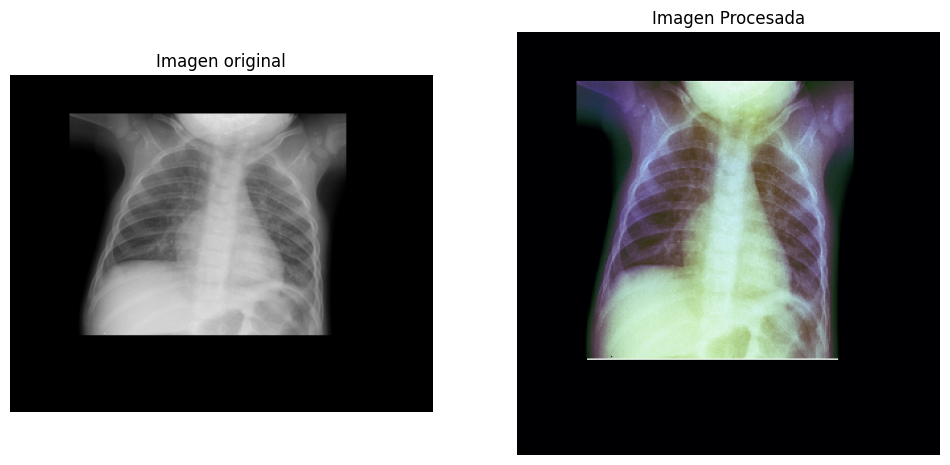

Imagen original: /kaggle/input/imagenesneumonianormalizadas/241754100529858293330953741004988387646_4dq0ju.png


In [4]:
X_train, X_test, y_train, y_test = data_preparation(path='/kaggle/input/')

In [5]:
# Obtener el número de imágenes en cada conjunto
num_train_images = len(X_train)
num_test_images = len(X_test)
num_train_labels = len(y_train)
num_test_labels = len(y_test)

# Imprimir los resultados
print(f"Número de imágenes en X_train: {num_train_images}")
print(f"Número de imágenes en X_test: {num_test_images}")
print(f"Número de etiquetas en y_train: {num_train_labels}")
print(f"Número de etiquetas en y_test: {num_test_labels}")

Número de imágenes en X_train: 554
Número de imágenes en X_test: 139
Número de etiquetas en y_train: 554
Número de etiquetas en y_test: 139


In [13]:
"""model callbacks"""
#Remover los directorios donde se encuentran guardados los modelos de entrenamientos previos
# Define the directory paths
directories = [
    "/kaggle/working/model1",
    "/kaggle/working/model2",
    "/kaggle/working/model3"
]

# Iterate over each directory and remove it if it exists
for directory in directories:
    if os.path.exists(directory):
        shutil.rmtree(directory)
        
checkpoint = ModelCheckpoint(filepath='/kaggle/working/model1/checkpoints/base_model/v_free/eps={epoch:03d}_valLoss={val_loss:.4f}.keras',
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

checkpoint2 = ModelCheckpoint(filepath='/kaggle/working/model2/checkpoints/base_model/v_free/eps={epoch:03d}_valLoss={val_loss:.4f}.keras',
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

checkpoint3 = ModelCheckpoint(filepath='/kaggle/working/model3/checkpoints/base_model/v_free/eps={epoch:03d}_valLoss={val_loss:.4f}.keras',
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='auto', verbose=1, min_delta=0.002)
#cb_list = [checkpoint, early_stopping]

In [7]:
"""Modelo principal"""
input_shape = X_train.shape[1:]  # Toma la forma de una muestra de X_train excluyendo el primer eje (el número de muestras)
classifier = model(input_shape=input_shape)
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(classifier.summary())
print('Numero de capas del modelo:', len(classifier.layers))

"""Modelo 2"""
input_shape = X_train.shape[1:]  # Toma la forma de una muestra de X_train excluyendo el primer eje (el número de muestras)
classifier2 = model2(input_shape=input_shape)
classifier2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(classifier.summary())
print('Numero de capas del modelo 2:', len(classifier2.layers))

"""Modelo 3"""
input_shape = X_train.shape[1:]  # Toma la forma de una muestra de X_train excluyendo el primer eje (el número de muestras)
classifier3 = model3(input_shape=input_shape)
classifier3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(classifier3.summary())
print('Numero de capas del modelo 3:', len(classifier3.layers))

Model: "binary_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer1 (Conv2D)            │ (None, 320, 320, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer1 (MaxPooling2D)   │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer1 (Dropout)        │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer2 (Conv2D)            │ (None, 160, 160, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer2 (MaxPooling2D)   │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer2 (Dropout)        │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer3 (Conv2D)            │ (None, 80, 80, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer3 (MaxPooling2D)   │ (None, 40, 40, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer3 (Dropout)        │ (None, 40, 40, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 819200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_layer1 (Dense)               │ (None, 128)            │   104,857,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_layer2 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,532,033 (402.57 MB)

 Trainable params: 105,532,033 (402.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Numero de capas del modelo: 14


Model: "binary_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer1 (Conv2D)            │ (None, 320, 320, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer1 (MaxPooling2D)   │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer1 (Dropout)        │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer2 (Conv2D)            │ (None, 160, 160, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer2 (MaxPooling2D)   │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer2 (Dropout)        │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer3 (Conv2D)            │ (None, 80, 80, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer3 (MaxPooling2D)   │ (None, 40, 40, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer3 (Dropout)        │ (None, 40, 40, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 819200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_layer1 (Dense)               │ (None, 128)            │   104,857,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_layer2 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,532,033 (402.57 MB)

 Trainable params: 105,532,033 (402.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Numero de capas del modelo 2: 11


Model: "binary_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer1 (Conv2D)            │ (None, 320, 320, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer1 (MaxPooling2D)   │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer1 (Dropout)        │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer2 (Conv2D)            │ (None, 160, 160, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer2 (MaxPooling2D)   │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer2 (Dropout)        │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 819200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_layer1 (Dense)               │ (None, 128)            │   104,857,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_layer2 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,941,697 (400.32 MB)

 Trainable params: 104,941,697 (400.32 MB)

 Non-trainable params: 0 (0.00 B)

None
Numero de capas del modelo 3: 11


In [8]:
# Entrenar el modelo principal
history = classifier.fit(x=X_train, y=y_train, 
                         callbacks=[checkpoint,early_stopping],
                         epochs=100,
                         batch_size=32,
                         verbose=1, 
                         validation_data=(X_test, y_test))

# Entrenar el modelo 2
history2 = classifier2.fit(x=X_train, y=y_train, 
                         callbacks=[checkpoint2,early_stopping],
                         epochs=100,
                         batch_size=32,
                         verbose=1, 
                         validation_data=(X_test, y_test))

Epoch 1/100


2024-06-05 17:31:12.058245: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,64,320,320]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,320,320]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-05 17:31:12.612643: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.55241, expected 2.75097
2024-06-05 17:31:12.612704: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.71292, expected 5.91148
2024-06-05 17:31:12.612725: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.6465, expected 4.84506
2024-06-05 17:31:12.612746: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Di

 1/18 ━━━━━━━━━━━━━━━━━━━━ 9:05 32s/step - accuracy: 0.6250 - loss: 0.6844

I0000 00:00:1717608697.231201     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.5002 - loss: 5.7551

2024-06-05 17:31:42.353181: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 319: 2.53475, expected 2.1213
2024-06-05 17:31:42.353784: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 69440: 2.26801, expected 1.85457
2024-06-05 17:31:42.354117: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 102199: 2.98434, expected 2.5709
2024-06-05 17:31:42.354149: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 102200: 2.75099, expected 2.33755
2024-06-05 17:31:42.354171: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 102400: 3.41391, expected 2.95749
2024-06-05 17:31:42.354189: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 102404: 3.5458, expected 3.08938
2024-06-05 17:31:42.354205: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 102421: 3.35188, expected 2.89546
2024-06-05 17:31:42.354222:

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 0.5004 - loss: 5.6994

2024-06-05 17:31:56.138358: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.827, expected 2.39585
2024-06-05 17:31:56.138430: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19: 3.28227, expected 2.85113
2024-06-05 17:31:56.138447: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26: 3.23679, expected 2.80564
2024-06-05 17:31:56.138466: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 2.65676, expected 2.22562
2024-06-05 17:31:56.138478: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 42: 3.18117, expected 2.75002
2024-06-05 17:31:56.138490: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 55: 3.15534, expected 2.7242
2024-06-05 17:31:56.138502: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 176: 3.08824, expected 2.65709
2024-06-05 17:31:56.138513: E external/local_xla/xl


Epoch 1: val_loss improved from inf to 6.24858, saving model to /kaggle/working/model1/checkpoints/base_model/v_free/eps=001_valLoss=6.2486.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5005 - loss: 5.6495 - val_accuracy: 0.4676 - val_loss: 6.2486
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5541 - loss: 1.9964
Epoch 2: val_loss did not improve from 6.24858
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.5539 - loss: 3.1683 - val_accuracy: 0.5252 - val_loss: 76.4232
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6554 - loss: 1.2760
Epoch 3: val_loss did not improve from 6.24858
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.6544 - loss: 1.7083 - val_accuracy: 0.4964 - val_loss: 9.0902
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6055 - loss: 2.4487
Epoch 4: val_loss did not improve from 6.24858
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.6052 - loss: 3.5826 - val_accuracy: 0.5468 - v

In [14]:
# Entrenar el modelo 3
history3 = classifier3.fit(x=X_train, y=y_train, 
                         callbacks=[checkpoint3,early_stopping],
                         epochs=100,
                         batch_size=32,
                         verbose=1, 
                         validation_data=(X_test, y_test))

Epoch 1/100
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8369 - loss: 0.3769
Epoch 1: val_loss improved from inf to 1.79709, saving model to /kaggle/working/model3/checkpoints/base_model/v_free/eps=001_valLoss=1.7971.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 415ms/step - accuracy: 0.8369 - loss: 0.3760 - val_accuracy: 0.5252 - val_loss: 1.7971
Epoch 2/100
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7228 - loss: 0.6165
Epoch 2: val_loss improved from 1.79709 to 0.87945, saving model to /kaggle/working/model3/checkpoints/base_model/v_free/eps=002_valLoss=0.8795.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - accuracy: 0.7290 - loss: 0.6018 - val_accuracy: 0.7122 - val_loss: 0.8795
Epoch 3/100
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8767 - loss: 0.3048
Epoch 3: val_loss did not improve from 0.87945
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.8736 - loss: 0.3086 - val_accuracy: 0.7482 - val_loss: 1.0203
Epoch 4/100
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/s

In [11]:
#Carga de los mejores modelos 
# Obtener el archivo del mejor modelo guardado - Modelo principal
model_files = glob.glob(os.path.join('/kaggle/working/model1/checkpoints/base_model/v_free/', '*.keras'))
best_model_file = max(model_files, key=os.path.getctime)  # Selecciona el archivo más reciente
best_model = load_model(best_model_file)

# Obtener el archivo del mejor modelo 2
model2_files = glob.glob(os.path.join('/kaggle/working/model2/checkpoints/base_model/v_free/', '*.keras'))
best_model2_file = max(model2_files, key=os.path.getctime)  # Selecciona el archivo más reciente
best_model2 = load_model(best_model2_file)





In [15]:
# Obtener el archivo del mejor modelo 3
model3_files = glob.glob(os.path.join('/kaggle/working/model3/checkpoints/base_model/v_free/', '*.keras'))
best_model3_file = max(model3_files, key=os.path.getctime)  # Selecciona el archivo más reciente
best_model3 = load_model(best_model3_file)

In [18]:
# Realizar predicciones en los datos de prueba para cada modelo
#Modelo 1
y_pred = best_model.predict(X_test)
y_pred2 = best_model2.predict(X_test)
y_pred3 = best_model3.predict(X_test)
# Convertir las predicciones en etiquetas binarias (0 o 1)
y_pred_binary = (y_pred > 0.5).astype(int)
y_pred2_binary = (y_pred2 > 0.5).astype(int)
y_pred3_binary = (y_pred3 > 0.5).astype(int)
# Imprimir las primeras 10 predicciones y sus etiquetas reales por cada modelo
print("\n ============ Primeras 10 predicciones =============")
print("Predicciones Modelo principal :", y_pred_binary[:20].flatten())
print("Predicciones Modelo 2:", y_pred2_binary[:20].flatten())
print("Predicciones Modelo 3:", y_pred3_binary[:20].flatten())
print("Etiquetas reales (primeras 10):", y_test[:20])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

 ============ Primeras 10 predicciones =============
Predicciones Modelo principal : [0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1]
Predicciones Modelo 2: [0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 0 1]
Predicciones Modelo 3: [0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1]
Etiquetas reales (primeras 10): [0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0]


In [40]:
# Calcular métricas de evaluación para cada modelo
# Modelo principal
accuracy1 = accuracy_score(y_test, y_pred_binary) * 100
precision1 = precision_score(y_test, y_pred_binary) * 100
recall1 = recall_score(y_test, y_pred_binary) * 100
f1_1 = f1_score(y_test, y_pred_binary) * 100

# Modelo 2
accuracy2 = accuracy_score(y_test, y_pred2_binary) * 100
precision2 = precision_score(y_test, y_pred2_binary) * 100
recall2 = recall_score(y_test, y_pred2_binary) * 100
f1_2 = f1_score(y_test, y_pred2_binary) * 100

# Modelo 3
accuracy3 = accuracy_score(y_test, y_pred3_binary) * 100
precision3 = precision_score(y_test, y_pred3_binary) * 100
recall3 = recall_score(y_test, y_pred3_binary) * 100
f1_3 = f1_score(y_test, y_pred3_binary) * 100

#Calculo de ROC-AUC
y_pred_model1_probs = classifier.predict(X_test)
roc_model1_auc = roc_auc_score(y_test, y_pred_model1_probs)

y_pred_model2_probs = classifier2.predict(X_test)
roc_model2_auc = roc_auc_score(y_test, y_pred_model2_probs)

y_pred_model3_probs = classifier3.predict(X_test)
roc_model3_auc = roc_auc_score(y_test, y_pred_model3_probs)

# Crear una tabla con pandas
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score','ROC-AUC'],
    'Modelo principal': [accuracy1, precision1, recall1, f1_1,roc_model1_auc ],
    'Model 2': [accuracy2, precision2, recall2, f1_2, roc_model2_auc],
    'Model 3': [accuracy3, precision3, recall3, f1_3, roc_model3_auc]
}
df = pd.DataFrame(data)

# Aplicar estilo a la tabla
styled_df = df.style.set_table_styles(
    [{'selector': 'tr:hover',
      'props': [('background-color', '#ffff99')]},
     {'selector': 'th',
      'props': [('background-color', '#0000ff'),
                ('color', 'white')]},
     {'selector': 'td',
      'props': [('border', '1px solid black')]}]
).format(precision=3)

# Mostrar la tabla con estilo
styled_df


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


,Metric,Modelo principal,Model 2,Model 3
0,Accuracy,58.273,69.784,79.137
1,Precision,66.667,66.990,77.273
2,Recall,49.351,89.610,88.312
3,F1 Score,56.716,76.667,82.424
4,ROC-AUC,0.750,0.749,0.824


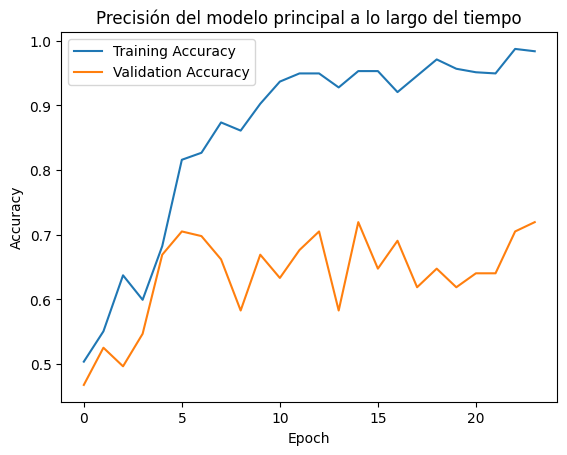

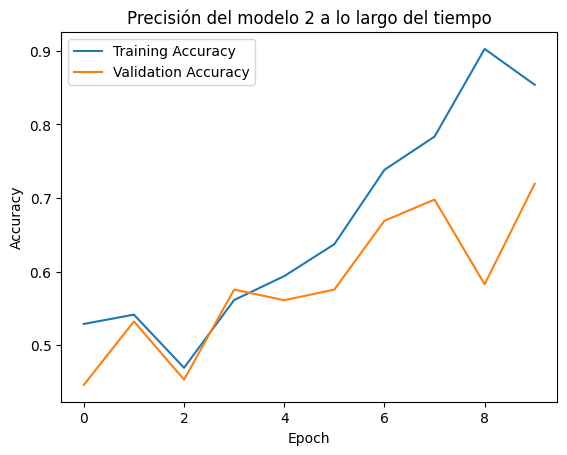

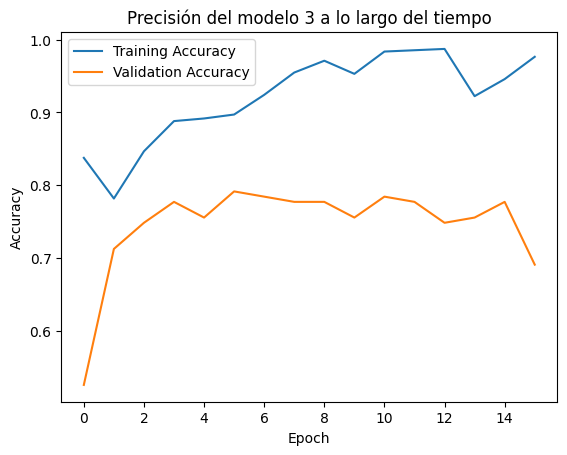

In [22]:
# Obtener la precisión del entrenamiento y la precisión de la validación del historial
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Crear un gráfico de líneas para visualizar la precisión a lo largo del tiempo
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Precisión del modelo principal a lo largo del tiempo')
plt.legend()
plt.show()


#modelo 2
# Obtener la precisión del entrenamiento y la precisión de la validación del historial
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']

# Crear un gráfico de líneas para visualizar la precisión a lo largo del tiempo
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Precisión del modelo 2 a lo largo del tiempo')
plt.legend()
plt.show()

#modelo 3
# Obtener la precisión del entrenamiento y la precisión de la validación del historial
train_accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy']

# Crear un gráfico de líneas para visualizar la precisión a lo largo del tiempo
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Precisión del modelo 3 a lo largo del tiempo')
plt.legend()
plt.show()

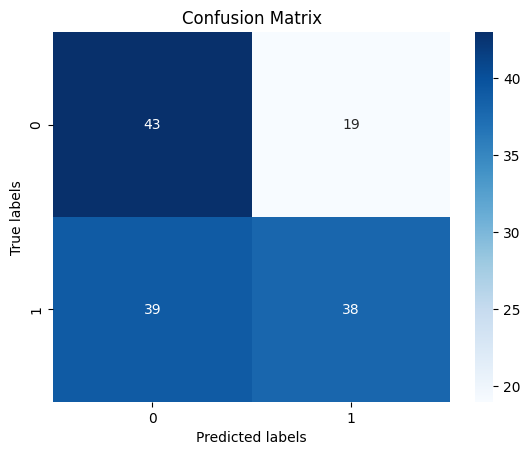

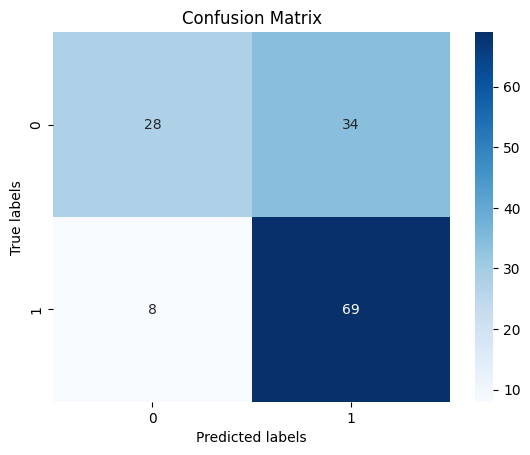

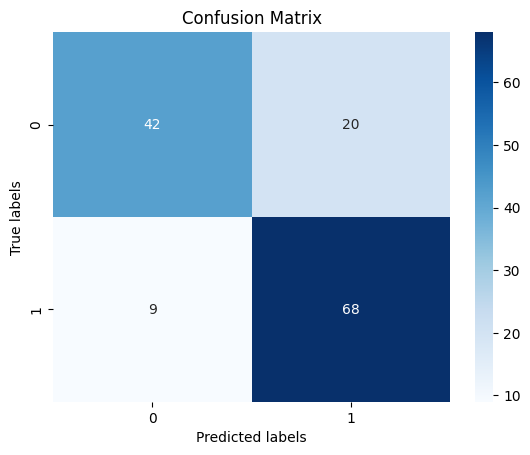

In [23]:
# Calcular la matriz de confusión
#Model principal
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Visualizar la matriz de confusión usando seaborn
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#Model 2
conf_matrix2 = confusion_matrix(y_test, y_pred2_binary)

# Visualizar la matriz de confusión usando seaborn
sns.heatmap(conf_matrix2, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#Model 3
conf_matrix3 = confusion_matrix(y_test, y_pred3_binary)

# Visualizar la matriz de confusión usando seaborn
sns.heatmap(conf_matrix3, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

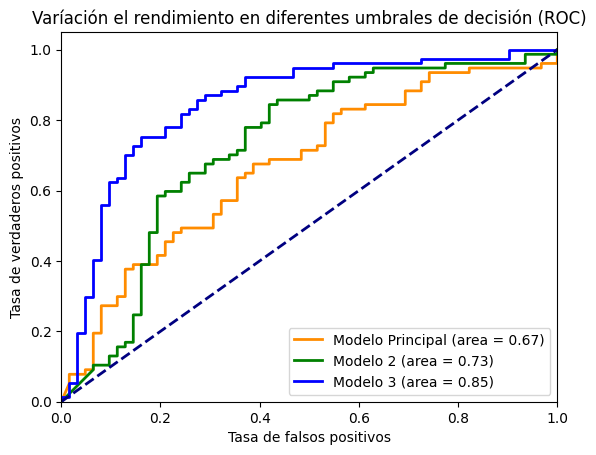

In [39]:
# Calcular la curva ROC y el área bajo la curva (AUC)
# Modelo Principal
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred)
roc_auc1 = auc(fpr1, tpr1)

# Modelo 2
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred2)
roc_auc2 = auc(fpr2, tpr2)

# Modelo 3
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred3)
roc_auc3 = auc(fpr3, tpr3)

# Crear un solo gráfico con las tres curvas ROC
plt.figure()

# Curva ROC del Modelo 1
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='Modelo Principal (area = %0.2f)' % roc_auc1)

# Curva ROC del Modelo 2
plt.plot(fpr2, tpr2, color='green', lw=2, label='Modelo 2 (area = %0.2f)' % roc_auc2)

# Curva ROC del Modelo 3
plt.plot(fpr3, tpr3, color='blue', lw=2, label='Modelo 3 (area = %0.2f)' % roc_auc3)

# Diagonal de referencia
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Configuración del gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Varíación el rendimiento en diferentes umbrales de decisión (ROC)')
plt.legend(loc="lower right")

# Mostrar el gráfico
plt.show()

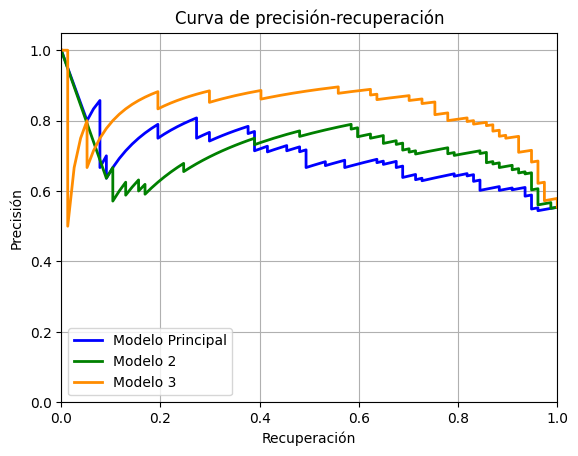

In [31]:
from sklearn.metrics import precision_recall_curve

# Calcular la curva de precisión-recall para los tres modelos
precision1, recall1, _ = precision_recall_curve(y_test, y_pred)
precision2, recall2, _ = precision_recall_curve(y_test, y_pred2)
precision3, recall3, _ = precision_recall_curve(y_test, y_pred3)

# Crear un solo gráfico con las tres curvas de precisión-recall
plt.figure()

# Curva de precisión-recall del Modelo 1
plt.plot(recall1, precision1, color='blue', lw=2, label='Modelo Principal')

# Curva de precisión-recall del Modelo 2
plt.plot(recall2, precision2, color='green', lw=2, label='Modelo 2')

# Curva de precisión-recall del Modelo 3
plt.plot(recall3, precision3, color='darkorange', lw=2, label='Modelo 3')

# Configuración del gráfico
plt.xlabel('Recuperación')
plt.ylabel('Precisión')
plt.title('Curva de precisión-recuperación')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.legend(loc="best")

# Mostrar el gráfico
plt.show()

In [ ]:
# Distribución desbalanceada
path_neumonia = '/kaggle/input/imagenesneumonianormalizadas'
path_normal = '/kaggle/input/imagenesnormalesnormalizadas'

num_neumonia = 1321*0.26
num_normal = 1321-num_neumonia

# Crear gráfico de pastel
labels = ['Neumonía', 'Normal']
sizes = [num_neumonia, num_normal]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode neumonia

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Distribución de clases')
plt.show()


In [ ]:
# Distribución desbalanceada
path_neumonia = '/kaggle/input/imagenesneumonianormalizadas'
path_normal = '/kaggle/input/imagenesnormalesnormalizadas'

num_neumonia = 1321*0.26
num_normal = 1321-num_neumonia

# Crear gráfico de pastel
labels = ['Neumonía', 'Normal']
sizes = [num_neumonia, num_normal]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode neumonia

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Distribución de clases')
plt.show()
